# <ins>Phase Two Final Project Submission</ins>

* Student name: Jesse Moore
* Student pace: Flex
* Scheduled project review date/time: Friday 10:00 AM
* Instructor name: Mark Barbour
* Blog post URL: [Linear Regression and the LINE Test](https://medium.com/@essejeroom/linear-regression-and-the-line-test-understanding-assumptions-for-valid-models-b40b1a1c039c)


<img src="ticketwindow.jpg" alt="Title Window" width="800"/>

# <ins>Overview</ins>
# Business Problem
### Our client has recognized the success of leading entertainment companies that are producing original video content and is eager to enter this expanding market. They plan to launch a new movie studio but have minimal experience in film production. Our objective is to analyze current box office trends to identify the most successful types of movies. 

### Based on our analysis, we will provide actionable recommendations to help the studio's leadership determine which genres are the most profitable for each category of production budget, as well determine what is the most profitable genre for each month of the year, and what directors are the most profitable for each budget category.

# Data Understanding

### We will analyze datasets from: 

* [Box Office Mojo](https://www.boxofficemojo.com/)
* [IMDB](https://www.imdb.com/)
* [Rotten Tomatoes](https://www.rottentomatoes.com/)
* [TheMovieDB](https://www.themoviedb.org/)
* [The Numbers](https://www.the-numbers.com/)

### In our analysis, we will create a new variable, 'roi' that will reflect the return on investment for each movie. We will also create a variable 'production_budget_category' that will allow us to more easily analyze the relationship between production budget and other features of our dataset. 

In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sqlite3
from zipfile import ZipFile
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.ticker as mtick

# Enabling inline plotting for Jupyter Notebooks
%matplotlib inline

In [2]:
#Some quality of life options for better formatting and visuals.

#Formatting our floats.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Setting style to 'dark' for better visuals
sns.set_style('dark')

In [3]:
#Loading our 'im.db.zip' database'
zip_file_path = 'zippedData/im.db.zip'
extract_folder = 'zippedData/extracted/'

#extracting the database with ZipFile
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [4]:
#Loading in our movie gross file
df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

In [5]:
#Dropping any NA values 
df.dropna(inplace=True)

In [6]:
#Let's import our 'tn.movie_budgets.csv.gz' dataset so that we can analyze the budgets to create a new 'roi' feature
new_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', on_bad_lines='skip', )

In [7]:
#Now we will create a merged_df with both of our datasets 

# Define the path to the SQLite database file
db_file_path = 'zippedData/extracted/im.db'

# Establish a connection to the SQLite database
conn = sqlite3.connect(db_file_path)

# SQL query to select necessary columns from movie_basics and movie_akas tables
query = '''
    SELECT 
    mb.movie_id,
    mb.primary_title,
    mb.start_year,
    mb.genres,
    ma.title,
    p.primary_name as director,
    mr.averagerating as rating
    FROM movie_basics as mb
    LEFT JOIN
    movie_akas as ma on mb.movie_id = ma.movie_id
    LEFT JOIN
    movie_ratings as mr on mb.movie_id = mr.movie_id
    LEFT JOIN 
    directors as d on mb.movie_id = d.movie_id
    LEFT JOIN 
    persons as p on d.person_id = p.person_id
'''

# Create a pandas DataFrame by executing the SQL query on the connected database
merged_df = pd.read_sql(query, conn)

#closing our connection to the SQLite database.
conn.close()

# Data Preparation
### Now, we must create a merged and clean dataset. This will be a multi-step process involving several datasets and joins. We will create a new feature, 'roi' that will reflect the mean total profit for each movie, and new variables 'production_budget_category' that will allow us to more easily analyze the effect production budget plays in our dataset.

In [8]:
#Dropping any rows where our title is duplicated. 
merged_df = merged_df.drop_duplicates(subset='primary_title', keep='first')

In [9]:
#Joining our two datasets to include information such as foreign and domestic gross.
joined_df = pd.merge(df, merged_df, how='inner', left_on='title', right_on='primary_title')

In [10]:
#Joining with our new_df dataframe to now include the production budget.
joined_df2 = pd.merge(joined_df, new_df, how='inner', left_on='title_x', right_on='movie')

In [11]:
#Converting the release date to datetime format. 
joined_df2['release_date'] = pd.to_datetime(joined_df2['release_date'])

In [12]:
#Dropping columns with values that we will not be analyzing as part of this analysis. 
#creating a list of columns that we won't need. 
columns_to_drop = ['studio', 'domestic_gross_x', 'foreign_gross', 'primary_title', 'start_year', 'title_y',
                   'id', 'movie', 'domestic_gross_y']

#dropping the columns. 
joined_df2.drop(columns_to_drop, axis=1, inplace=True)

In [13]:
#Cleaning the 'production_budget' and 'worldwide_gross' columns so that we can create our 'roi' variable.
#creating a list of our columns to clean.
columns_to_clean = ['production_budget', 'worldwide_gross']

#cleaning the columns.
joined_df2[columns_to_clean] = joined_df2[columns_to_clean].replace('[/$,]', '', regex=True).astype(float)

In [14]:
#dropping NA columns as they are irrelevant to our purposes today.
joined_df2.dropna(inplace=True)

 Now we must create a 'roi' feature to evaluate how much money our movies are actually making. Then we will continue with our data cleaning and grouping. 

In [15]:
#creating our 'roi' feature by subtracting our 'production_budget' data from our 'worldwide_gross' data.
joined_df2['roi'] = joined_df2['worldwide_gross'] - joined_df2['production_budget']

In [16]:
#Renaming our title_x' column to 'title' for readability and dropping columns unneeded for now. 
joined_df2.rename(columns={'title_x': 'title'}, inplace=True)

In [17]:
#We are going to want to use our 'release_date' column to plot how 'roi' has changed, so let's convert that into datetime format.
joined_df2['release_date'] = pd.to_datetime(joined_df2['release_date'])

In [18]:
#While we are at it let's add a 'release_month' column for future plotting.
joined_df2['release_month'] = joined_df2['release_date'].dt.strftime('%B')

In [19]:
#convert genre strings into lists
joined_df2['genres'] = joined_df2['genres'].str.split(',')

In [20]:
#exploding our dataset based upon 'genres'
joined_df2_exploded = joined_df2.explode('genres')

In [21]:
#Transforming our 'roi' and 'production_budget' columns to reflect this genre split.
joined_df2_exploded['roi'] = joined_df2_exploded.groupby('title')['roi'].transform(lambda x: x / x.count())
joined_df2_exploded['production_budget'] = joined_df2_exploded.groupby('title')['production_budget'].transform(lambda x: x / x.count())

### It is necessary to create a function now so that we can subdivide our dataset using the quantiles for our 'production_budget' category. First we will get the quantiles for our 'production_budget' column so that we can assign a categorical descriptor to each move based upon what budget range it falls into. 

In [22]:
#getting our quantiles
quantiles = joined_df2_exploded['production_budget'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0])
print(quantiles)

0.00       33333.33
0.20     5000000.00
0.40    10000000.00
0.60    16666666.67
0.80    35000000.00
1.00   137500000.00
Name: production_budget, dtype: float64


In [23]:
#changing this to a list so that we can use it in our function.
quantiles = list(quantiles)

In [24]:
#Creating our function that will help us create a 'production_budget_category' variable. 
#Note that we will assign our categories using our quantiles to allow us to re-use this function should our dataset change,
#for example.

def categorize_budget(budget, quantile_list):
    if budget <= int(quantile_list[1]):
        return 'Lower'
    elif budget > quantile_list[1] and budget <= quantile_list[2]:
        return 'Lower Middle'
    elif budget > quantile_list[2] and budget <= quantile_list[3]:
        return 'Middle'
    elif budget > quantile_list[3] and budget <= quantile_list[4]:
        return 'Upper Middle'
    elif budget < quantile_list[5]:
        return 'Upper'


## Now we will explode our dataset based upon 'genres' as the 'genres' values are often subdivided so we end up with unrealistic values such as 'Adventure / Animation / Comedy' that are hard to understand. This will help us avoid statistical errors like misattributing profits to multi-genre categories instead of individual genres, inflating or deflating genre-specific insights, and skewing trend analysis due to inconsistent classifications.

First we will find the highest grossing directors for each of these categories. 

<img src="cinemaexcitement.jpg" alt="Cinema Audience Excited" width="800"/>

In [25]:
#Creating our new dataframe using groupby to show us the median roi for each director. 
director_profits_df = joined_df2_exploded.groupby(['director'])[(['roi', 'production_budget'])].median().reset_index()

In [26]:
#using our function on the dataframe
director_profits_df['production_budget_category'] = director_profits_df['production_budget'].apply(lambda x: categorize_budget(x, quantiles))

In [27]:
#Creating our dataframe with the highest profiting directors for each budget category.

highest_grossing_directors_by_category_df = (
    director_profits_df.loc[director_profits_df.groupby('production_budget_category')['roi'].idxmax(),
        ['production_budget_category', 'director', 'roi', 'production_budget']]
).sort_values('production_budget')


In [28]:
#Now we are grouping by genres and production_budget_category so that we can examine the genres with the highest ROI for each production 
#budget category.
genre_profits_df = joined_df2_exploded.groupby(['genres'])[(['roi', 'production_budget'])].median().reset_index()

In [29]:
#Using our function on the dataframe to create our production_budget_category feature here.
genre_profits_df['production_budget_category'] = genre_profits_df['production_budget'].apply(lambda x: categorize_budget(x, quantiles))

In [30]:
#Here we are creating a df with the highest grossing genre for each production budget category. 

highest_grossing_genres_by_category_df = (
    genre_profits_df.loc[genre_profits_df.groupby('production_budget_category')['roi'].idxmax(),
        ['production_budget_category', 'genres', 'roi', 'production_budget']]
).sort_values('production_budget')

In [31]:
#resetting the index
highest_grossing_genres_by_category_df = highest_grossing_genres_by_category_df.reset_index()

In [32]:
# #creating values to assist in our plotting
# min_profit = highest_grossing_directors_by_category_df['roi'].min()
# max_profit = highest_grossing_directors_by_category_df['roi'].max()

# ytick_min = min_profit - 10e6
# ytick_max = max_profit + 10e7

# step_size = (ytick_max - ytick_min) // 10
# # yticks = np.arange(ytick_min, ytick_max, step_size)

In [33]:
#creating our highest grossing genre by month dataframe using groupby.
#we are finding the median roi to account for outliers. 
highest_grossing_genre_by_month = joined_df2_exploded.groupby(['release_month', 'genres'])['roi'].median().reset_index()

In [34]:
#Determining what the highest grossing genres by month are. 
id_max = highest_grossing_genre_by_month.groupby('release_month')['roi'].idxmax()

In [35]:
#filtering our dataframe based upon this information.
highest_grossing_genre_by_month = highest_grossing_genre_by_month.loc[id_max].reset_index(drop=True)

In [36]:
#sorting our highest grossing directors dataframe
highest_grossing_directors_by_category_df = highest_grossing_directors_by_category_df.sort_values(by='roi', ascending=False)

In [37]:
#sorting our highest grossing directors dataframe
highest_grossing_genres_by_category_df = highest_grossing_genres_by_category_df.sort_values(by='roi', ascending=False)

In [38]:
#sorting our dataframe. 
highest_grossing_genre_by_month = highest_grossing_genre_by_month.sort_values(by='roi', ascending=True)

In [39]:
#sorting our highest genre by month dataframe.
highest_grossing_genre_by_month.sort_values(by='roi', inplace=True, ascending=False)

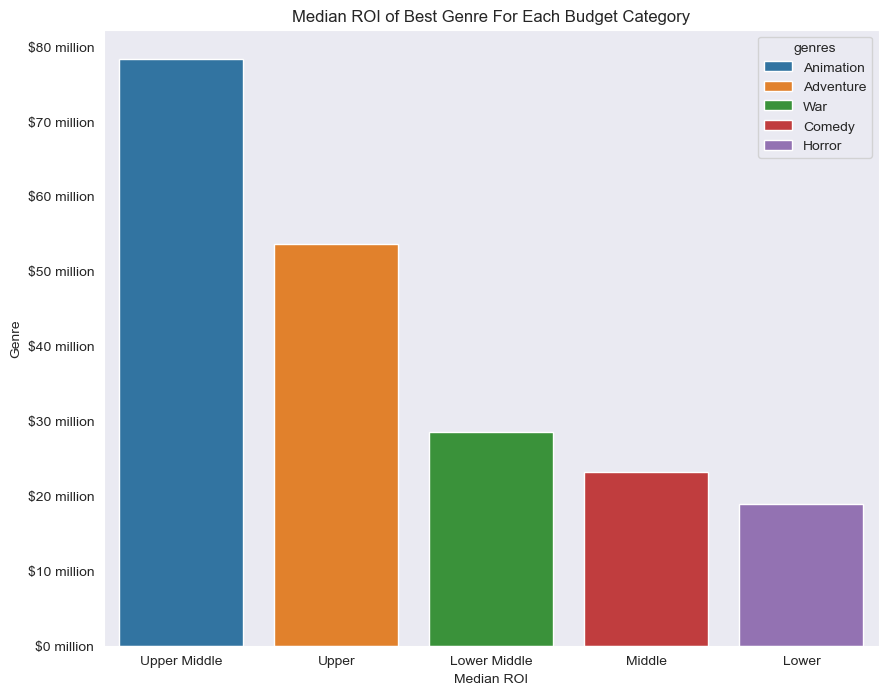

In [40]:
#creating our plot for the highest grossing genres by category. 

plt.figure(figsize=(10,8)) 

sns.barplot(data=highest_grossing_genres_by_category_df, 
            x='production_budget_category', 
            y='roi',
            hue='genres')


plt.title('Median ROI of Best Genre For Each Budget Category')
plt.xlabel('Median ROI')
plt.ylabel('Genre')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(
    lambda x, _: f'${x/1e6:,.0f} million' if x < 1e9 else f'${x/1e9:,.1f} billion'

))

ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  
ax.yaxis.set_minor_locator(MultipleLocator(5e6)) 

plt.savefig('genre_by_budget.png');

### Animated films yield the highest median ROI within the 'Upper Middle' budget category and hold the highest median ROI across the entire dataset.

### Actionable Insight:
### Invest in an animated film within the 'Upper Middle' budget category.

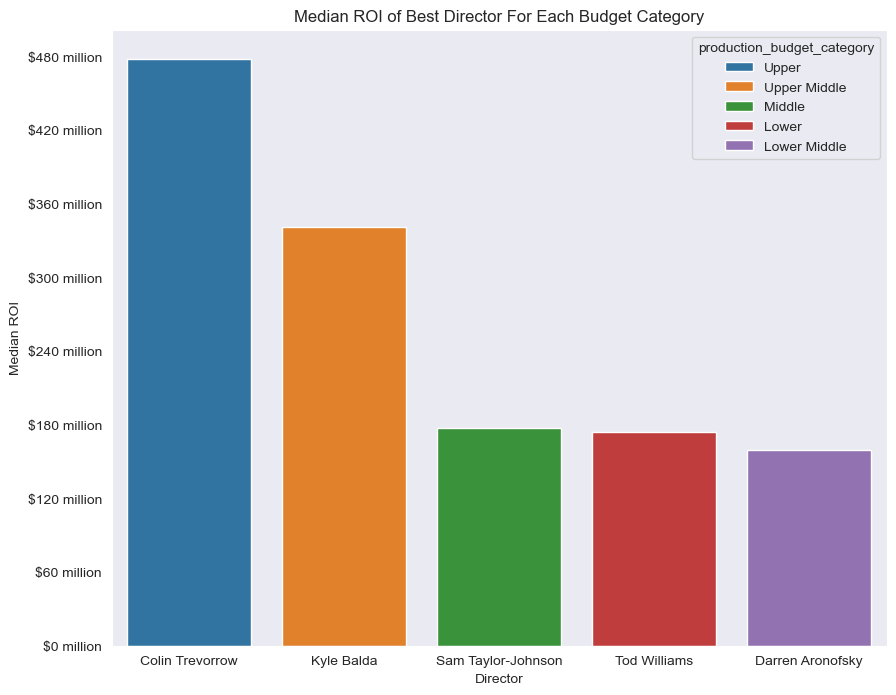

In [41]:
#creating out Plot of Median ROI for Best Director
plt.figure(figsize=(10,8))
sns.barplot(data=highest_grossing_directors_by_category_df, x='director', y='roi', hue='production_budget_category')

plt.title('Median ROI of Best Director For Each Budget Category')
plt.xlabel('Director')
plt.ylabel('Median ROI')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(
    lambda x, _: f'${x/1e6:,.0f} million' if x < 1e9 else f'${x/1e9:,.1f} billion'

))

ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  
ax.yaxis.set_minor_locator(MultipleLocator(5e6)) 

plt.savefig('director_by_budget.png');

### These directors achieve the highest median ROI for their respective budget categories. Hiring any of them would be a strong strategic move.

### Actionable Insight:
### Hire Kyle Balda to direct our animated film in the 'Upper Middle' budget category.



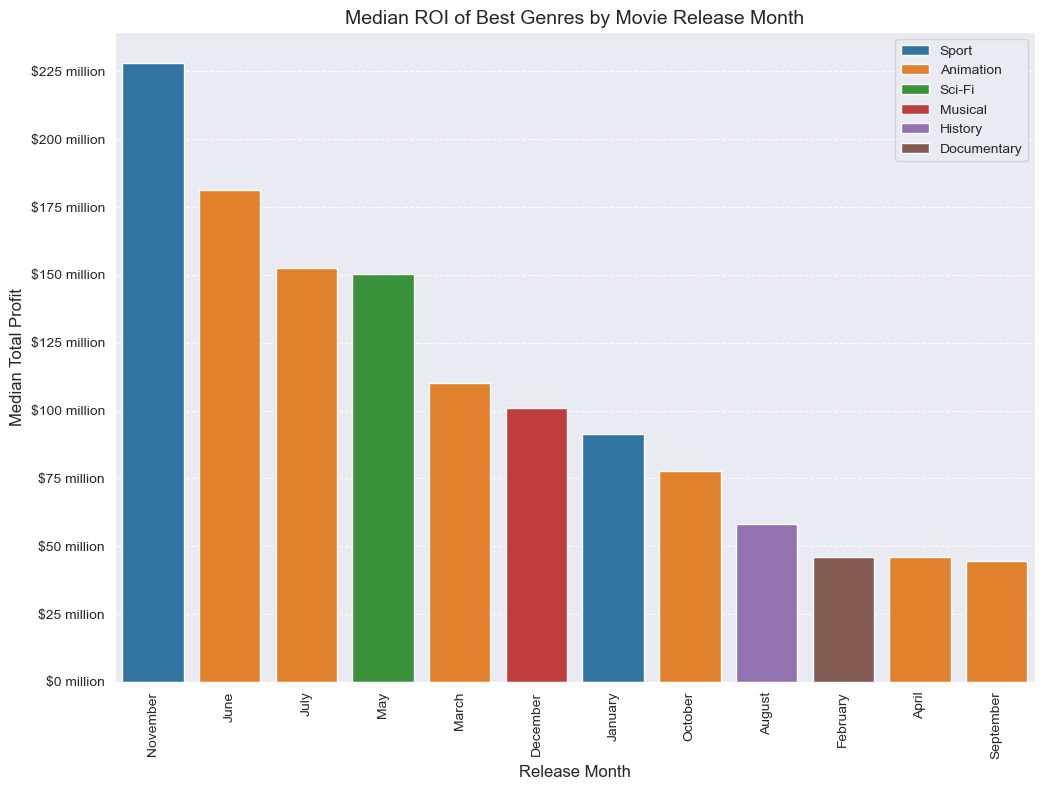

In [43]:
# Create the bar plot
plt.figure(figsize=(10,8))

sns.barplot(data=highest_grossing_genre_by_month, 
            x='release_month', 
            y='roi',
            hue='genres')

# Adding labels to the axes
plt.xlabel('Release Month', fontsize=12)
plt.ylabel('Median Total Profit', fontsize=12)

# Adding a title
plt.title('Median ROI of Best Genres by Movie Release Month', fontsize=14)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Adding gridlines for better readability of the y-axis values
plt.grid(axis='y', linestyle='--', alpha=0.9)

# Adding the legend
plt.legend(loc='upper right', fontsize=10)

# Adjust the layout to ensure everything fits without overlap
plt.tight_layout()

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(
    lambda x, _: f'${x/1e6:,.0f} million' if x < 1e9 else f'${x/1e9:,.1f} billion'

))

ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  
ax.yaxis.set_minor_locator(MultipleLocator(5e6)) 
# Save the plot as a PNG image and using ';' to show the plot. 
plt.savefig('Average_ROI_by_Movie_Release_Month.png');

### The highest median ROI is observed in November, with 'Sport' as the top-performing genre. However, 'Animation' consistently delivers strong returns across most months, likely due to the requirement that children be accompanied by ticket-buying adults.

### Actionable Insight:
### Release the animated film in June to maximize ROI.

## Conclusion

### This analysis explored the relationships between return on investment, production budget categories, and genres, as well as the impact of directors on ROI. Additionally, we identified the highest median ROI genres for each month.

### To achieve the highest possible ROI, we recommend producing an animated film within the 'Upper Middle' budget range (16.6M - 35M), hiring Kyle Balda as the director, and releasing the film in June.

### Why Might Our Analysis Not Fully Address the Problem?

### External market factors: The analysis does not account for potential external factors that could impact movie success, such as economic conditions, competition from other studios, or changing consumer tastes. These factors could significantly influence box office performance and should be considered in future analyses.

### Assumption of historical trends: The analysis is based on historical data, which assumes that past trends will continue. However, the entertainment industry is dynamic, and market conditions, consumer preferences, and industry trends can change rapidly. The insights gained may only be applicable to the current context and may not fully predict future performance.

### Overreliance on roi as a metric: roi is an important indicator, but it does not capture the full picture. Other factors, such as audience satisfaction, critical reception, or brand-building for the studio, could be equally important in determining the long-term success of a movie studio.

<img src="cinemaaudience.jpg" alt="Cinema Audience" width="800"/>

### Future Steps

### To improve the analysis and make it more comprehensive in the future, we should consider the following:

### Incorporate additional data: Gathering more detailed data on factors like social media engagement could provide deeper insights into what drives success. 

### Track evolving trends over time: The business should regularly update its analysis to track shifts in movie-goer preferences, genre popularity, and market conditions. This would allow the company to adjust its strategies dynamically rather than relying on static insights.